In [1]:
import sys
sys.path.append('..')

In [2]:
from copy import deepcopy
from random import randint

from library.solution import Solution
from library.problems.int_bin import IntBinSolution
from library.algorithms.hill_climbing import hill_climbing

## Solving IntBin with Hill Climbing - Part 2

To solve the IntBin problem using Hill Climbing, we need to define how to navigate the solution space. In hill climbing, the search space is navigated with the concept of neighborhood.

The algorithm requires the solution to have a `get_neighbors()` method. Therefore, we can **extend** the `IntBinSolution` and create a `IntBinHillClimbingSolution` that implements the `get_neighbors()` method.

![IntBin Hill Climbing Solution Inheritance](images/intbin-hillclimbing-solution.png)

There are two options to get the neighbors of a solution:
- Option 1 - Integer neighborhood: Each integer x has at most two neighbors: x-1 and x+1, except for boundaries (1 and 15).
- Option 2 - Bit flip neighborhood: Each binary representation of an integer x has as neighbors any other binary with a bit flipped.

In the previous notebook, we implemented Option 1 and observed that starting from different random initial solutions led to different final solutions, not always reaching the global optimum (1111 in binary).

Today, we’ll redefine the neighborhood using Option 2 – Bit Flip Neighborhood - to analyze how it impacts the search process.

#### Option 2 - Bit flip neighborhood: Each binary representation of an integer x has as neighbors any other binary with a bit flipped.

Let's create a `IntBin_BitFlip_HillClimbingSolution` class that inherits from `IntBinSolution` and implements the `get_neighbors()` method.

In [3]:
class IntBin_BitFlip_HillClimbingSolution(IntBinSolution):
    def get_neighbors(self):
        neighbors = []
        # Convert binary string to list of bits
        repr_list = list(self.repr)

        # Bit flip
        for idx, digit in enumerate(repr_list):
            neighbor_list_repr = deepcopy(repr_list)
            if digit == '1':
                neighbor_list_repr[idx] = '0'
            elif digit == '0':
                neighbor_list_repr[idx] = '1'
            
            # Transform back to string
            neighbor_repr = "".join(neighbor_list_repr)
            neighbors.append(IntBin_BitFlip_HillClimbingSolution(neighbor_repr))

        return neighbors

Let's test it

In [4]:
# Initialize random solution
solution = IntBin_BitFlip_HillClimbingSolution('1011')
print('Solution', solution)

neighbors = solution.get_neighbors()
print('Neighbors:')
for neighbor in neighbors:
    print(neighbor)

Solution 1011
Neighbors:
0011
1111
1001
1010


And finally apply the hill climbing algorithm by passing it an intial random solution

In [5]:
initial_solution = IntBin_BitFlip_HillClimbingSolution()
best_solution = hill_climbing(initial_solution, maximization=True, verbose=True)

print('Best solution', best_solution)

Current solution: 0011 with fitness 2
Neighbor: 1011 with fitness 3
Neighbor: 0111 with fitness 3
Neighbor: 0001 with fitness 1
Neighbor: 0010 with fitness 1
Current solution: 0111 with fitness 3
Neighbor: 1111 with fitness 4
Neighbor: 0011 with fitness 2
Neighbor: 0101 with fitness 2
Neighbor: 0110 with fitness 2
Current solution: 1111 with fitness 4
Neighbor: 0111 with fitness 3
Neighbor: 1011 with fitness 3
Neighbor: 1101 with fitness 3
Neighbor: 1110 with fitness 3
Best solution 1111


Let's see if the final solution changes with multiple runs

In [6]:
for _ in range(10):
    initial_solution = IntBin_BitFlip_HillClimbingSolution()
    print(hill_climbing(initial_solution, maximization=True))

1111
1111
1111
1111
1111
1111
1111
1111
1111
1111


Different runs always result in the same final best solution. And this solution is actually the global optimum! Why does this happen?

In Option 1, the neighborhood of an integer is defined as the integers immediately below and above it. This approach can lead to local optima, as the search is limited to neighboring integers.

However, when we define the neighborhood of an integer as the integers that can be obtained by flipping a bit in its binary representation, every solution has at least one neighbor that has one more '1', unless the solution is the number 15 (represented as 1111 in binary), which is the global optimum. This means that there are no local optima in the fitness landscape because it is always possible to improve.

The next section will explain this concept in more detail, with illustrative examples.

The final implementations of `IntBinSolution` and `IntBinHillClimbingSolution` can be found in `library/problems/int_bin.py`.

`IntBinHillClimbingSolution` corresponds to `IntBin_BitFlip_HillClimbingSolution` since it implements the best way of exploring the search space via the neighborhood.

# Importance of fitness landscape

We've observed that when solving the IntBin problem using hill climbing, defining the neighborhood of a solution as the integers immediately below and above it (Option 1) often leads to getting stuck in local optima. In contrast, when we define the neighborhood as the integers obtained by flipping a single bit in the binary representation (Option 2), we consistently reach the global optimum.

To understand why this happens, it is useful to think of the fitness landscape.

A **fitness landscape  is a visual intuition of the difficulty of the algorithm in solving the problem**. It represents how solutions relate to their fitness and how they relate to each other via the **neighborhood**. Each solution is a point in the landscape, with its **height** indicating how good it is.

Visualizing a fitness landscape requires:
1. A well-defined search space - The set of all possible solutions.
2. A fitness function - A way to evaluate each solution.
3. A neighborhood structure - Defines how solutions are connected.
4. A way to position/order solutions - This can be challenging in high-dimensional spaces.

Generally, it is very difficult to draw a fitness landscape because the search space is usually huge, the solutions' representation is high dimensional, and the neighborhood of solutions is also high dimensional.

We can only visualize up to 3 dimensions. And there is always one dimension (the height), that is reserved to visualizing the fitness. This height will tell us how good or bad a solution is.

### 2D fitness landscapes

![Fitness landscape 2D](images/fitness-landscape.jpeg)

In a 2D landscape, solutions are positioned on the x-axis, and fitness is represented on the y-axis. Each solution has 2 neighbors: the solution showing before and the solution showing after on the x-axis.

Using 2 dimensions, we can visualize the fitness landscape of any problem where solutions have these properties:
1. **A 1D Search Space** - Solutions must be representable as a single value.
2. **Neighboring solutions must be adjacent in a 1D space** – Each solution should have neighboring solutions that can be placed adjacent to it in 1D space (e.g., integers, real numbers, sequences with a well-defined order).


### 3D fitness landscapes

![Fitness landscape #D](images/fitness-landscape-3d.png)

A 3D fitness landscape represents problems where solutions have a **natural 2D structure** (x and y axes), and fitness can be plotted as height (z-axis).

To be visualizable in 3D, a problem must have:
1. **A 2D Search Space**: Solutions must be representable as pairs (x, y) (e.g, continuous arrays or problems with two main features)
2. **Neighboring solutions must be adjacent in a 2D plane**: Each solution should have neighboring solutions that can be placed adjacent to it in 2D space (e.g., moving left/right or up/down).


### IntBin Fitness landscape

Based on the above explanation, we can determine whether the **fitness landscape of IntBin solutions** can be visualized, **depending on how we define the neighborhood structure**.

#### Option 1 - Integer Neighborhood (Visualizable in 2D)

How can we visualize a 2D fitness landscape?
- 1D Search Space: Each solution is an integer in the x-axis ✅
- Neighbors are adjacent in the x-axis: the integers below and above.  ✅

#### Option 2 - Bit Flip Neighborhood (Not Visualizable in 2D or 3D)

Why can't we visualize in a 2D landscape? Let's check the properties:
- 1D Search Space: Each solution is an integer in the x-axis ✅
- Neighboring solutions should be adjacent in a 1D space: Each solution has 4 neighbors. Besides not being adjacent on the x-axis, they are 4 neighbors, wich would make it impossible to even arrane them in the x-axis ❌

Why can't we visualize in a 3D landscape? Let's check the properties:
- 2D Search Space: Each solution is an integer / its binary representation (4 bits = 4 features) ❌
- Neighboring solutions should be adjacent in a 2D space: Sinze solutions can not be represented in a 2D space, neither can their neighborhood. ❌

Even though we cannot visualize the fitness landscape with the Bit Flip neighborhood, we can still infer its properties: the fitness landscape is smooth and has no local optima.

#### Conclusions

The key takeway is that the way we define the neighborhood influences the fitnes landscape. **Since many optimization algorithms - such as hill climbing - navigate the search space using neighborhood structures, their sucess is super influenced by the properties of the fitness landscape.**

If we define the neighborhood using Option 1 we only have 2 neighbors, each with a certain fitness value. Some solutions have neighbors with better fitness, while others don't, leading to local optima. As a result, the fitness landscape is rugged, with multiple local optima that can trap optimization algorithms.

On the other hand, if we define it using Option 2, we have 4 neighbors, each with a certain fitness value. For every solution, there is at least one neighbor with better fitness. This means that the fitness landscape is smooth, and as no local optima, meaning hill climbing will always reach the global optimum.

# Visualizing fitness landscapes

To better understand how to visualize a fitness landscape, let’s introduce a new optimization problem, IntMax, where each solution can be represented in 1D search space, and has exactly two neighbors, just like IntBin with integer neighborhood.

### IntMax Optimization Problem

**Description:** The IntMax problem consists of finding the biggest integer between 1 and some N

**Search space:** Integers from 1 to 15.

**Fitness function:** f(x)=x (i.e., the number itself).

**Goal:** Maximize f(x).

Let's start by defining a IntMax solution

In [7]:
class IntMaxSolution(Solution):
    def __init__(self, repr=None):
        super().__init__(repr=repr)
    
    def fitness(self):
        return self.repr
    
    def random_initial_representation(self):
        return randint(1, 15)

Let's test it

In [8]:
solution = IntMaxSolution(3)

print(f'Solution {solution} with fitness {solution.fitness()}')

Solution 3 with fitness 3


#### Solving IntMax with HillClimbing

To use hill climbing to solve IntMax we need to have solutions that implement the `get_neighbors` method. Let's implement that.

In [9]:
class IntMaxHillClimbingSolution(IntMaxSolution):
    def get_neighbors(self):
        if self.repr == 1:
            return [IntMaxHillClimbingSolution(2)]
        elif self.repr == 15:
            return [IntMaxHillClimbingSolution(14)]
        else:
            return [IntMaxHillClimbingSolution(self.repr-1), IntMaxHillClimbingSolution(self.repr+1)]

And test it:

In [10]:
# Initialize random solution
solution = IntMaxHillClimbingSolution(3)
print('Solution', solution)

neighbors = solution.get_neighbors()
print('Neighbors:')
for neighbor in neighbors:
    print(neighbor)

Solution 3
Neighbors:
2
4


We can now apply hill climbing to the IntMax problem by passing it an initial solution.

In [11]:
initial_solution = IntMaxHillClimbingSolution()
best_solution = hill_climbing(initial_solution, maximization=True, verbose=True)

print('Best solution', best_solution)

Current solution: 15 with fitness 15
Neighbor: 14 with fitness 14
Best solution 15


Let's run it multiple times to see what happens

In [12]:
for _ in range(10):
    initial_solution = IntMaxHillClimbingSolution()
    print(hill_climbing(initial_solution, maximization=True))

15
15
15
15
15
15
15
15
15
15


We always reach the same final solution, and this solution is the global optimum! Just like in IntBin with neighborhood Option 2 - Bit Flip Neighborhood.

### Recall IntBin Solution

In the previous notebook, we implemented the `IntBin_IntNeighborhood_HillClimbingSolution` class, which defines the `get_neighbors()` method. This method defined a solution’s neighbors as the integers immediately below and above its current value.

In [13]:
class IntBin_IntNeighborhood_HillClimbingSolution(IntBinSolution):
    def get_neighbors(self):
        # Convert binary string representation into integer
        int_repr = int(self.repr, 2)

        if int_repr == 1:
            return [IntBin_IntNeighborhood_HillClimbingSolution(format(2, '04b'))]
        elif int_repr == 15:
            return [IntBin_IntNeighborhood_HillClimbingSolution(format(14, '04b'))]
        else:
            return [IntBin_IntNeighborhood_HillClimbingSolution(format(int_repr-1, '04b')), IntBin_IntNeighborhood_HillClimbingSolution(format(int_repr+1, '04b'))]

### Visualizing 2D fitness landscapes

Let's create a function to visualize 2D landscapes

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def draw_2D_fitness_landscape(ordered_solution_space):
    fitness_values = [solution.fitness() for solution in ordered_solution_space]

    x_labels = [repr(solution) for solution in ordered_solution_space]

    sns.lineplot(x=x_labels, y=fitness_values)

    plt.ylabel('Fitness')
    plt.xlabel('Solutions')
    plt.show()

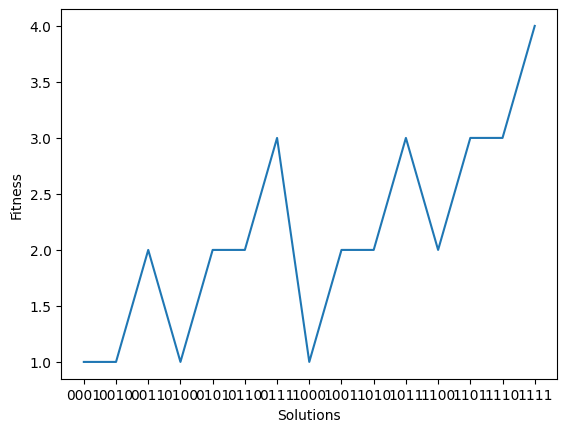

In [15]:
ordered_solution_space = [IntBinSolution(format(i, '04b')) for i in range(1, 16)]

draw_2D_fitness_landscape(ordered_solution_space)

We can see that the fitness landscape of IntBin is rugged and full of local optima. Since Hill Climbing is a greedy algorithm that always seeks to improve the current solution, it often gets trapped in these local optima and fails to reach the global optimum (1111).

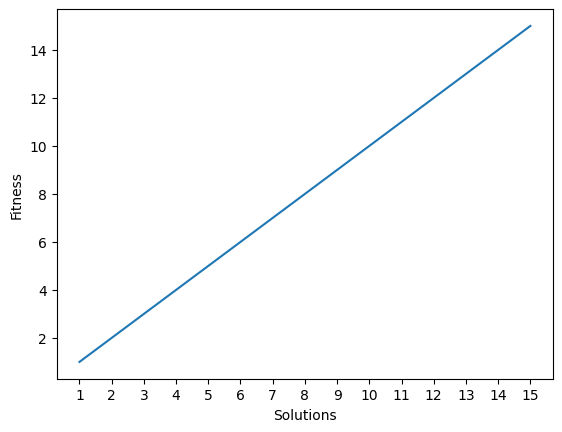

In [16]:
ordered_solution_space = [IntMaxSolution(i) for i in range(1, 16)]

draw_2D_fitness_landscape(ordered_solution_space)

In IntMax, there is always a neighbor solution with a better fitness value that the current solution. This is similar to what occurred when we switched from IntBin Option 1 to Option 2! By doing so, we transform the fitness landscape into a unimodal one, where the only optimum is the global optimum, and there are no local optima.

The final implementations of `IntMaxSolution` and `IntMaxHillClimbingSolution` can be found in `library/problems/int_max.py`